In [89]:
import numpy as np
import scipy.stats as s
import configparser
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 6)
import matplotlib.pyplot as plt
import scipy.stats as ss
from datetime import datetime

from nltk import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/marat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [90]:
dataset = pd.read_csv('downloads/sber2.csv', na_values='None')
print(dataset.columns)

Index(['Is_human', 'Text', 'Predict'], dtype='object')


In [98]:
k_bots = dataset['operator'] == 'bot'
k_humans = dataset['operator'] == 'human'
plt.hist(dataset[k_bots]['discriminator'], label='bot', alpha=0.3)
plt.hist(dataset[k_humans]['discriminator'], label='human', alpha=0.3)
plt.legend()
plt.show()

KeyError: 'operator'

In [12]:
dataset

,Is_human,Text,Predict
0,0,<COR_START> Вчера в платежном поручении на пе...,0.403804
1,1,"<COR_START> добрый вечер , я создала платежны...",0.555778
2,0,"<COR_START> Добрый день , при активации эл по...",0.518519
3,0,<COR_START> Здравствуйте ! Почему я второй де...,0.556421
4,0,"<COR_START> Добрый день . Подскажите , пожалу...",0.483685
5,1,<COR_START> интересует кредит для организации...,0.354521
6,1,<COR_START> <PAUSE> <ANS_START> Служба техн...,0.259566
7,1,"<COR_START> Здравствуйте , заблокирован моб б...",0.908006
8,1,<COR_START> код подтверждения изменения почты...,0.527716
9,1,<COR_START> как сделать выборку по входящим п...,0.511076


In [92]:
# data = pd.read_csv(config['out_tsv'], sep='\t')
data = pd.read_csv('target/sber2.tsv', sep='\t', na_values='None')

In [93]:
def plot_beta(bot, human, rnd, title='', legend=True):
    neg, pos = bot
    x = np.linspace(ss.beta.ppf(0.01, pos, neg), ss.beta.ppf(0.99, pos, neg), 100)
    label = 'bot {}/({}+{})={:.2f}'.format(pos, neg, pos, pos/(neg+pos))
    plt.plot(x, ss.beta.pdf(x, pos, neg), 'r-', lw=5, alpha=0.6, label=label)

    neg, pos = human
    x = np.linspace(ss.beta.ppf(0.01, pos, neg), ss.beta.ppf(0.99, pos, neg), 100)
    label = 'human {}/({}+{})={:.2f}'.format(pos, neg, pos, pos/(neg+pos))
    plt.plot(x, ss.beta.pdf(x, pos, neg), 'g-', lw=5, alpha=0.6, label=label)
       
    neg, pos = rnd
    x = np.linspace(ss.beta.ppf(0.01, pos, neg), ss.beta.ppf(0.99, pos, neg), 100)
    label = 'random {}/({}+{})={:.2f}'.format(pos, neg, pos, pos/(neg+pos))
    plt.plot(x, ss.beta.pdf(x, pos, neg), 'b-', lw=5, alpha=0.6, label=label)
    
    
    ztest = sm.stats.proportions_ztest([bot[1], human[1]], [sum(bot), sum(human)], alternative='two-sided')
    plt.title('{} (Fisher test z={:.3f}, pvalue={:.4f})'.format(title, *ztest))
    if legend:
        plt.legend()
    plt.xlim(0, 1)

In [94]:
def compare(data, eps=1e-2):
    res = {}
    for g, d in data.groupby(['operator', 'is_meaningful']):
        x = d['question'].apply(lambda x: len(word_tokenize(x)))
        res[g] = (x <= 15).sum()
#         res[g] = len(d)

    bot = [res.get(('bot', 0), eps), res.get(('bot', 1), eps)]
    human = [res.get(('human', 0), eps), res.get(('human', 1), eps)]
    rnd = [res.get(('random', 0), eps), res.get(('random', 1), eps)]

    chi = s.chisquare(bot, f_exp=human)
    ztest = sm.stats.proportions_ztest([bot[1], human[1]], [sum(bot), sum(human)], alternative='two-sided')
    
    return [chi.pvalue, ztest], [bot, human, rnd], human[1] / (human[0] + human[1]), bot[1] / (bot[1] + bot[0]), rnd[1] / (rnd[1] + rnd[0])

Index(['chat_id', 'user', 'question_id', 'operator', 'question', 'answer',
       'time_asked', 'time_answered', 'is_meaningful', 'discriminator_score'],
      dtype='object')
overall 1587 ([4.9951179132231516e-13, (-3.7074796666729632, 0.00020933221844733027)], [[120, 209], [109, 341], [241, 116]], 0.75777777777777777, 0.63525835866261393, 0.32492997198879553)


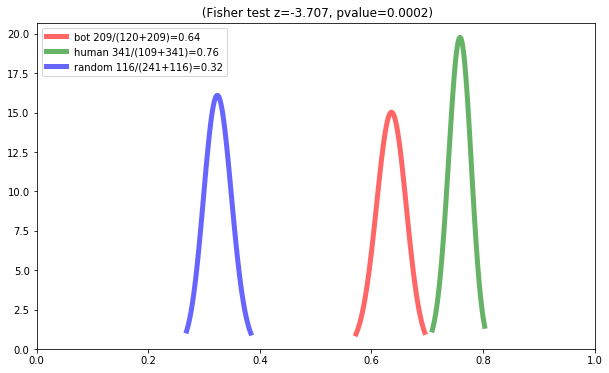

In [95]:
print(data.columns)

c = compare(data)
print('overall', len(data), c)

_, [bot, human, rnd], *_2 = c
plot_beta(bot, human, rnd)
plt.show()

### Статистика по толокерам персонально

Aleksey@yoptar 40 ([7.6167687270290582e-100, (-3.121784667246144, 0.001797583664099761)], [[66, 49], [8, 23], [49, 19]], 0.74193548387096775, 0.42608695652173911, 0.27941176470588236)
Alexey@ 30 ([7.6167687270290582e-100, (-3.121784667246144, 0.001797583664099761)], [[66, 49], [8, 23], [49, 19]], 0.74193548387096775, 0.42608695652173911, 0.27941176470588236)
Dilyara@baymurzinadilyara 40 ([7.6167687270290582e-100, (-3.121784667246144, 0.001797583664099761)], [[66, 49], [8, 23], [49, 19]], 0.74193548387096775, 0.42608695652173911, 0.27941176470588236)
Marat@tsundokum 16 ([7.6167687270290582e-100, (-3.121784667246144, 0.001797583664099761)], [[66, 49], [8, 23], [49, 19]], 0.74193548387096775, 0.42608695652173911, 0.27941176470588236)
Mikhail@MBurtsev 60 ([7.6167687270290582e-100, (-3.121784667246144, 0.001797583664099761)], [[66, 49], [8, 23], [49, 19]], 0.74193548387096775, 0.42608695652173911, 0.27941176470588236)
Mikhail@mikhail_arkhipov 42 ([7.6167687270290582e-100, (-3.12178466724614

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:4544: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


P.@not_there 30 ([7.6167687270290582e-100, (-3.121784667246144, 0.001797583664099761)], [[66, 49], [8, 23], [49, 19]], 0.74193548387096775, 0.42608695652173911, 0.27941176470588236)
Rafael@ai_rafael 48 ([7.6167687270290582e-100, (-3.121784667246144, 0.001797583664099761)], [[66, 49], [8, 23], [49, 19]], 0.74193548387096775, 0.42608695652173911, 0.27941176470588236)
Yura@yurakuratov 29 ([7.6167687270290582e-100, (-3.121784667246144, 0.001797583664099761)], [[66, 49], [8, 23], [49, 19]], 0.74193548387096775, 0.42608695652173911, 0.27941176470588236)


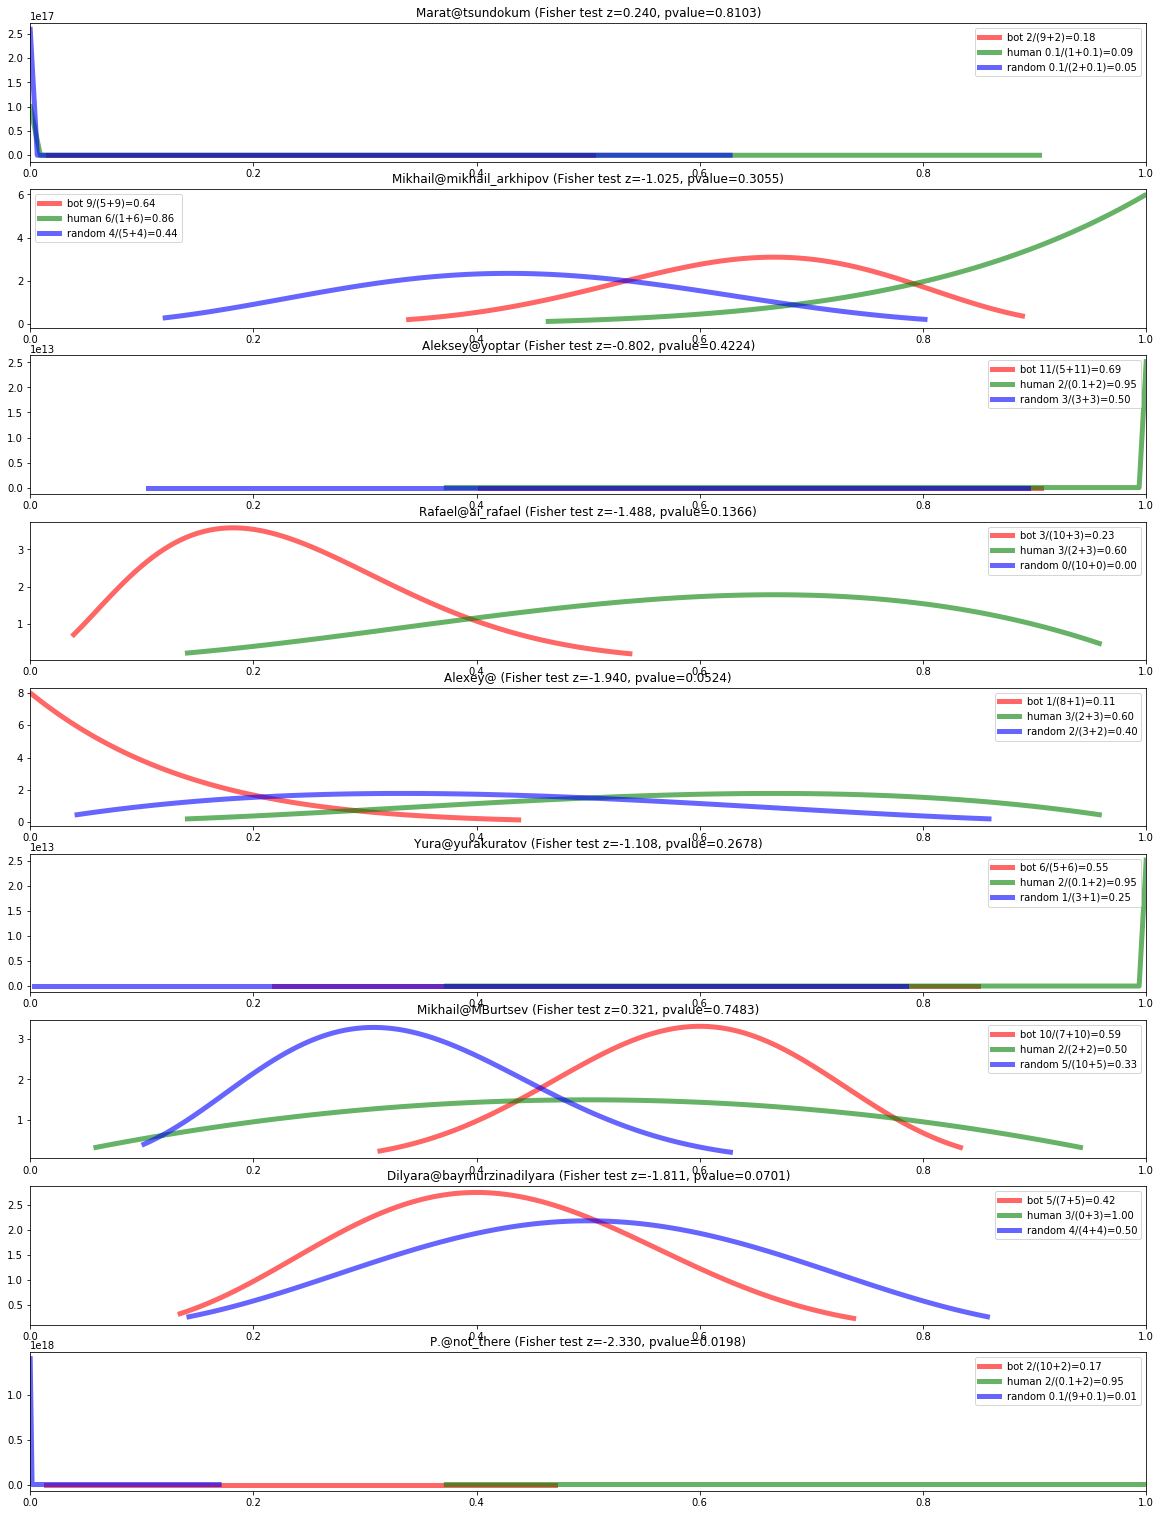

In [65]:
order = {c: i for i, c in enumerate(data['user'].unique())}

plt.figure(figsize=(20, len(order)*3))
for g, d in data.groupby('user'):
    try:
        _, [bot, human, rnd], *__ = compare(d, eps=0.1)
        plt.subplot(len(order), 1, order[g]+1)
        plot_beta(bot, human, rnd, title=g, legend=True)
        print(g, len(d), c)
    except KeyError as ex:
        print(ex)
    except ZeroDivisionError:
        print('\t>>> Not enough data for {}'.format(g))
plt.show()

### Статистика по новым и опытным толокерам

In [66]:
data.user.unique()

array(['Marat@tsundokum', 'Mikhail@mikhail_arkhipov', 'Aleksey@yoptar',
       'Rafael@ai_rafael', 'Alexey@', 'Yura@yurakuratov',
       'Mikhail@MBurtsev', 'Dilyara@baymurzinadilyara', 'P.@not_there'], dtype=object)

In [67]:
# exp_users = ['Alexey@', 'Mikhail@MBurtsev', 'Mikhail@mikhail_arkhipov',
#        'Aleksey@yoptar', 'Dilyara@bdilya', 'Mary@vimary',
#        'Marat@tsundokum', 'Varvara@varvara_konstantinovna', 'Eugeniya 🐙@fogside',
#             'Yura@yurakuratov']
# new_users = ['Roman@', 'Maksim@', 'Leonid@leonidpugachev', 'Olga@olgalind', 'Anatoly@anatoliipotapov']

# def newbie(username):
#     if username in new_users:
#         return 'newbie'
#     elif username in exp_users:
#         return 'expert'
#     else:
#         return 'unknown'


# data['newbie'] = data['user'].apply(newbie)

# order = {c: i for i, c in enumerate(data['newbie'].unique())}

# for g, d in data.groupby('newbie'):
#     try:
#         c = compare(d)
#         _, [bot, human, rnd], *_2 = c
#         print(g, len(d), )
#         plt.subplot(2, 1, order[g]+1)
#         plot_beta(bot, human, rnd, title=g)
#     except KeyError as ex:
#         print(ex)
# plt.show()        

### Влияние дискриминатора


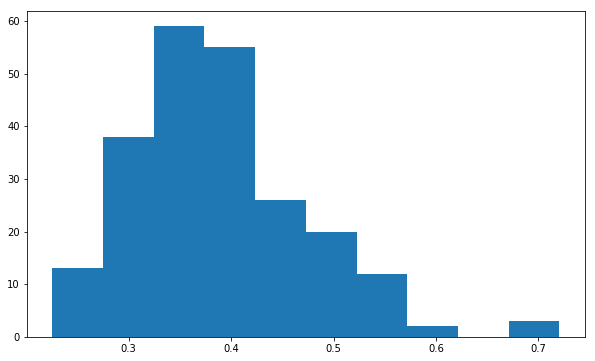

In [68]:
v = data['discriminator_score'].values
plt.hist(v[~np.isnan(v)])
plt.show()

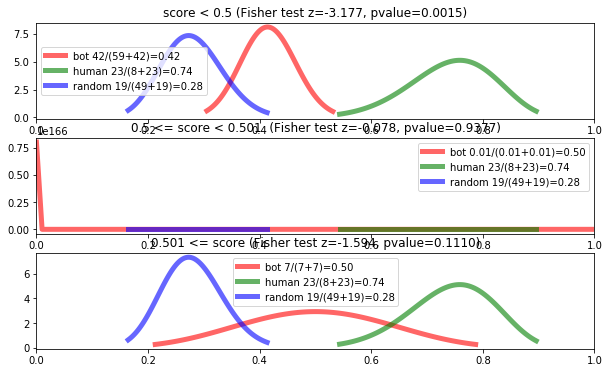

In [69]:
t1 = 0.5
t2 = 0.501
data['score_class'] = np.digitize(data['discriminator_score'], [t1, t2])

for class_id, class_title in [(0, f'score < {t1}'),
                              (1, f'{t1} <= score < {t2} '),
                              (2, f'{t2} <= score')]:
    plt.subplot(3, 1, class_id+1)
    k = (data['operator'] != 'bot') | ((data['operator'] == 'bot') & (data['score_class'] == class_id))
    _, [human, bot, rnd], *__ = compare(data[k])
    plot_beta(human, bot, rnd, title=class_title)
plt.show()

### Влияние длинны вопроса

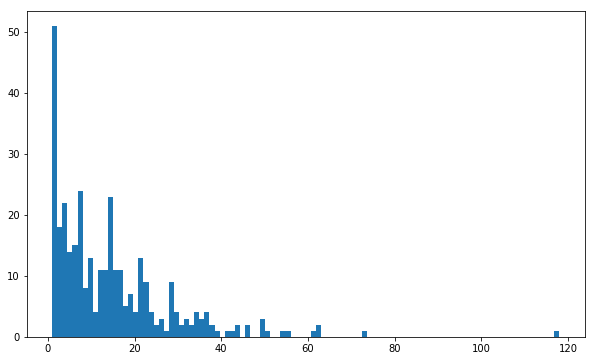

In [70]:
plt.hist(data['question'].apply(lambda x: len(word_tokenize(x))), bins=100)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/proportion.py:786: RuntimeWarning: invalid value encountered in true_divide
  prop = count * 1. / nobs
/usr/local/lib/python3.6/dist-packages/statsmodels/stats/proportion.py:802: RuntimeWarning: divide by zero encountered in true_divide
  nobs_fact = np.sum(1. / nobs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= s

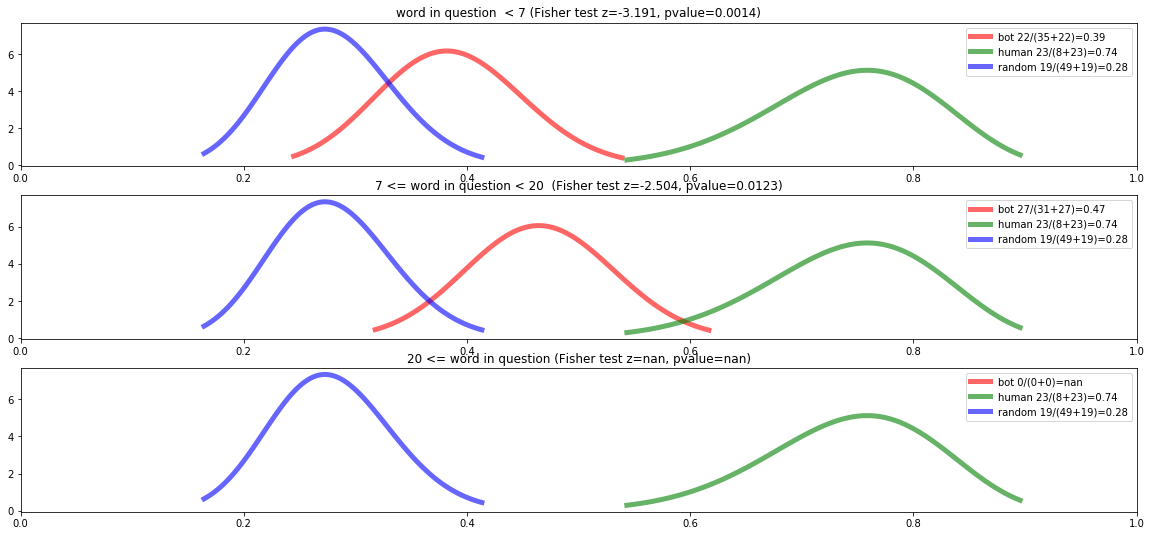

In [71]:
t1 = 7
t2 = 20
data['question_len_class'] = np.digitize(data['question'].apply(lambda x: len(word_tokenize(x))), [t1, t2])

plt.figure(figsize=(20, 3*3))
for class_id, class_title in [(0, f'word in question  < {t1}'),
                              (1, f'{t1} <= word in question < {t2} '),
                              (2, f'{t2} <= word in question')]:
    plt.subplot(3, 1, class_id+1)
    k = (data['operator'] != 'bot') | ((data['operator'] == 'bot') & (data['question_len_class'] == class_id))
    _, [human, bot, rnd], *__ = compare(data[k])
    plot_beta(human, bot, rnd, title=class_title)
plt.show()

### Влияние длины вопроса

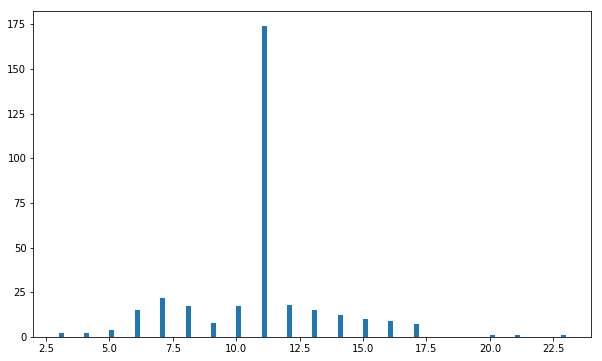

In [72]:
plt.hist(data['answer'].apply(lambda x: len(word_tokenize(x))), bins=100)
plt.show()

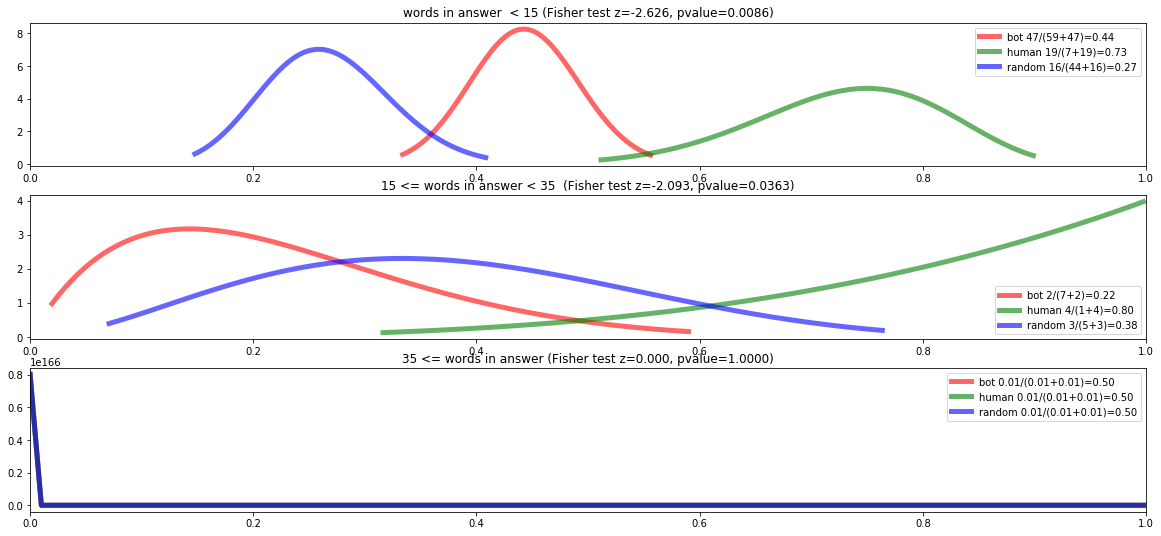

In [73]:
t1 = 15
t2 = 35
data['answer_len_class'] = np.digitize(data['answer'].apply(lambda x: len(word_tokenize(x))), [t1, t2])

plt.figure(figsize=(20, 3*3))
for class_id, class_title in [(0, f'words in answer  < {t1}'),
                              (1, f'{t1} <= words in answer < {t2} '),
                              (2, f'{t2} <= words in answer')]:
    plt.subplot(3, 1, class_id+1)
    k = (data['answer_len_class'] == class_id)
    _, [human, bot, rnd], *__ = compare(data[k])
    plot_beta(human, bot, rnd, title=class_title)
plt.show()

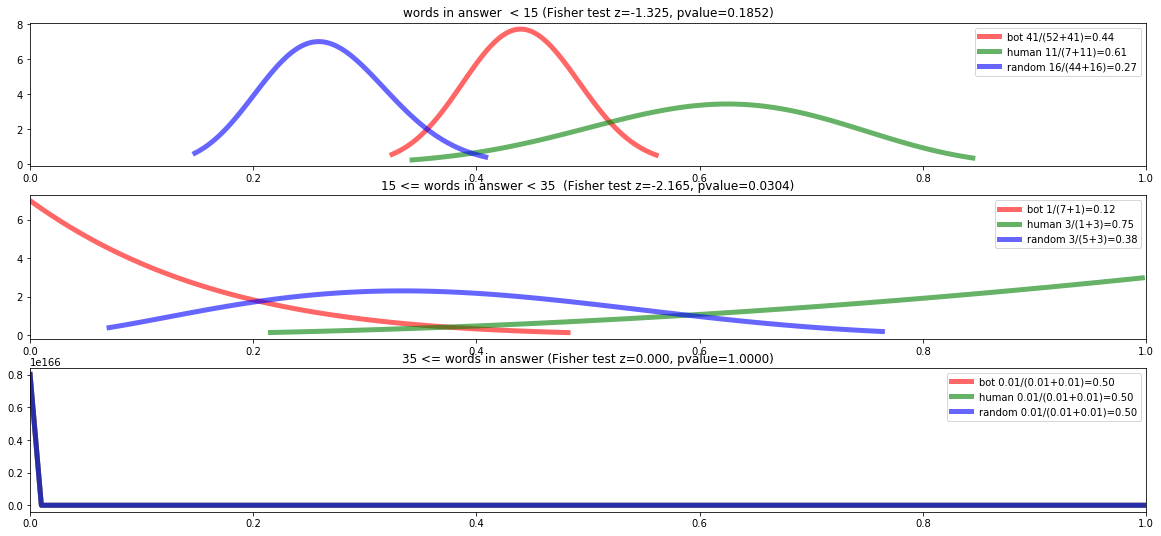

In [74]:
t1 = 15
t2 = 35
data['answer_len_class'] = np.digitize(data['answer'].apply(lambda x: len(word_tokenize(x))), [t1, t2])

plt.figure(figsize=(20, 3*3))
for class_id, class_title in [(0, f'words in answer  < {t1}'),
                              (1, f'{t1} <= words in answer < {t2} '),
                              (2, f'{t2} <= words in answer')]:
    plt.subplot(3, 1, class_id+1)
    k = (data['answer_len_class'] == class_id)
    _, [human, bot, rnd], *__ = compare(data[k & ((data['operator'] == 'random') | (data['discriminator_score'] < 0.5))])
    plot_beta(human, bot, rnd, title=class_title)
plt.show()

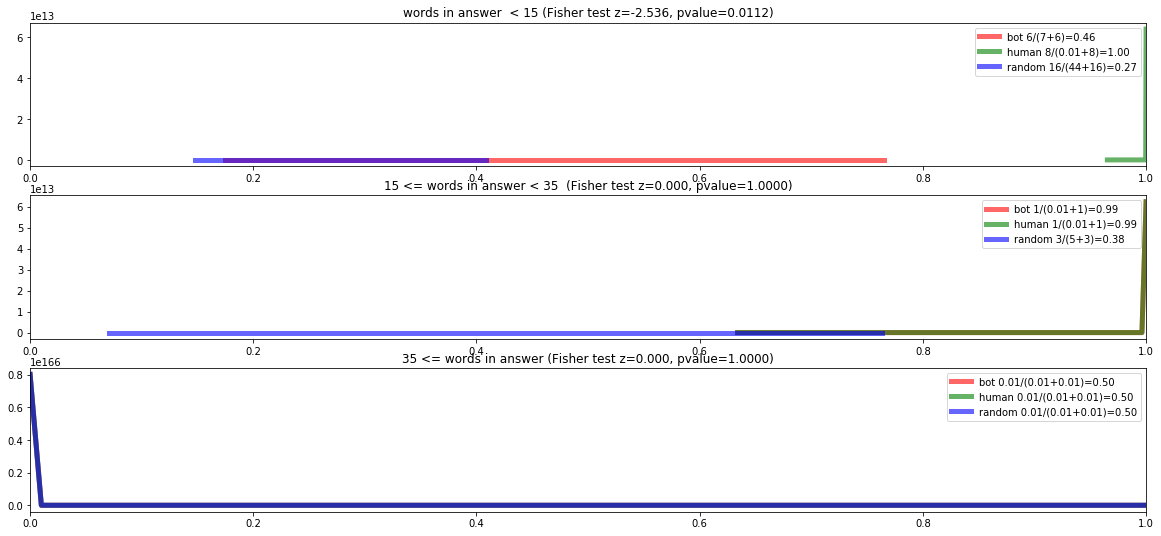

In [75]:
t1 = 15
t2 = 35
data['answer_len_class'] = np.digitize(data['answer'].apply(lambda x: len(word_tokenize(x))), [t1, t2])

plt.figure(figsize=(20, 3*3))
for class_id, class_title in [(0, f'words in answer  < {t1}'),
                              (1, f'{t1} <= words in answer < {t2} '),
                              (2, f'{t2} <= words in answer')]:
    plt.subplot(3, 1, class_id+1)
    k = (data['answer_len_class'] == class_id)
    _, [human, bot, rnd], *__ = compare(data[k & ((data['operator'] == 'random') | (data['discriminator_score'] >= 0.5))])
    plot_beta(human, bot, rnd, title=class_title)
plt.show()

In [76]:
def get_question(text):
    context, answer = text.strip().split('<ANS_START>')
    cs = context.replace('<COR_START>', ';').replace('<MAN_START>', ';').replace('<PAUSE>', ';')
    cs = [c.strip() for c in cs.split(';') if c.strip()]
    if cs:
        return cs[-1]
    else:
        ''
    
q = pd.read_csv('downloads/sber2.csv', sep=',', quotechar='"')['Text'].apply(get_question)


overall 335 ([7.6167687270290582e-100, (-3.121784667246144, 0.001797583664099761)], [[66, 49], [8, 23], [49, 19]], 0.74193548387096775, 0.42608695652173911, 0.27941176470588236)


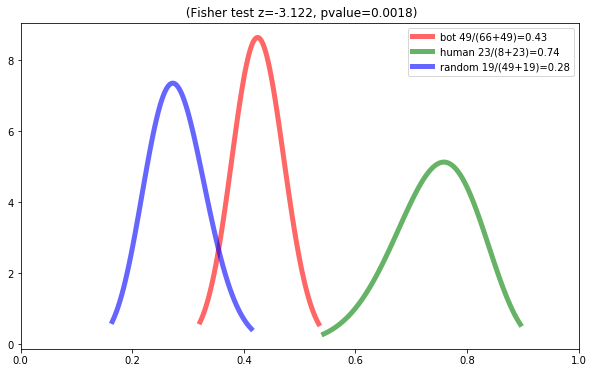

In [77]:
dt = datetime(2017, 11, 21, 15, 0)

c = compare(data[data['time_asked'].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f")) > dt])
print('overall', len(data), c)

_, [bot, human, rnd], *_2 = c
plot_beta(bot, human, rnd)
plt.show()

In [78]:
data[has_hello]

,chat_id,user,question_id,operator,question,answer,time_asked,time_answered,is_meaningful,discriminator_score,score_class,question_len_class,answer_len_class
5,314318558,Mikhail@mikhail_arkhipov,10993,human,здравствуйте,"Римма Мнацагановна , система работает в штатн...",2017-11-24T14:29:07.656213,2017-11-24T14:29:11.243419,0,0.419284,0,0,1
13,404239771,Rafael@ai_rafael,4685,human,"Здравствуйте ! Создала документ "" Заявление о ...","Служба технической поддержки Сбербанка , меня...",2017-11-24T14:29:18.064410,2017-11-24T14:29:29.742114,0,0.286566,0,2,0
21,163008481,Alexey@,4219,human,Здравствуйте,Как я могу к Вам обращаться ?,2017-11-24T14:29:43.528139,2017-11-24T14:29:45.932192,1,0.278783,0,0,0
23,163008481,Alexey@,11168,random,"здравствуйте , заказала справку об отсутствии ...","Служба технической поддержки Сбербанка , меня ...",2017-11-24T14:29:45.932256,2017-11-24T14:29:49.688402,0,NaN,2,2,0
25,2483750,Yura@yurakuratov,11116,random,здравствуйте ! по чему не могу произвести опла...,"Виктор Леоевич , в таком случае необходимо обр...",2017-11-24T14:29:27.203548,2017-11-24T14:29:53.009645,0,NaN,2,1,0
29,163008481,Alexey@,5337,random,Здравствуйте .,"Служба технической поддержки Сбербанка , меня...",2017-11-24T14:29:53.287253,2017-11-24T14:29:55.395810,1,NaN,2,0,0
31,163008481,Alexey@,11252,human,здравствуйте . Как посмотреть в выписке зачисл...,"Служба технической поддержки Сбербанка , меня...",2017-11-24T14:29:55.395865,2017-11-24T14:29:58.131855,0,0.259922,0,1,0
33,314318558,Mikhail@mikhail_arkhipov,5620,bot,Здравствуйте . Создал платежное поручение . Ка...,"Служба технической поддержки Сбербанка , меня ...",2017-11-24T14:29:57.366872,2017-11-24T14:29:59.298818,1,0.317715,0,1,0
52,314318558,Mikhail@mikhail_arkhipov,5762,random,"Здравствуйте Здравствуйте ! Подскажите , произ...","Андрей Николаевич , в графе "" Сообщение "" вы у...",2017-11-24T14:30:10.002037,2017-11-24T14:30:27.419457,0,NaN,2,2,0
59,35077854,Aleksey@yoptar,11162,bot,"здравствуйте , вопрос выше","Уточните , пожалуйста , работаете в новой верс...",2017-11-24T14:30:33.589772,2017-11-24T14:30:43.346719,1,0.405954,0,0,0


1587 -> 1226


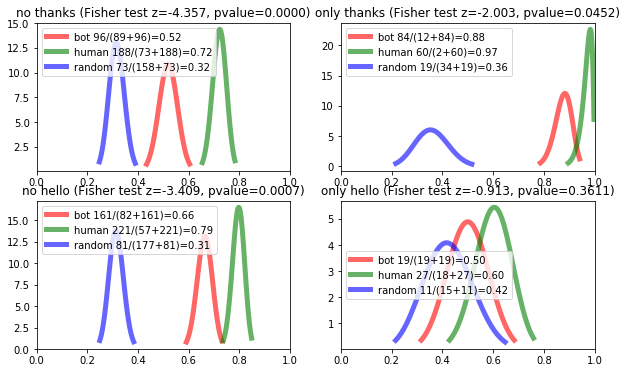

In [97]:
d = data[data['answer'].apply(lambda x: len(x.split())<=35)]
print('{} -> {}'.format(len(data), len(d)))

def has_word(word):
    def f(x):
        return word in x.lower()
    return f
has_thanks = d['question'].apply(has_word('спасибо'))
has_hello = d['question'].apply(has_word('здравствуйте'))

plt.subplot(2, 2, 1)
c = compare(d[~has_thanks])
plot_beta(*c[1], title='no thanks')

plt.subplot(2, 2, 2)
c = compare(d[has_thanks])
plot_beta(*c[1], title='only thanks')

plt.subplot(2, 2, 3)
c = compare(d[~has_hello])
plot_beta(*c[1], title='no hello')

plt.subplot(2, 2, 4)
c = compare(d[has_hello])
plot_beta(*c[1], title='only hello')


plt.show()

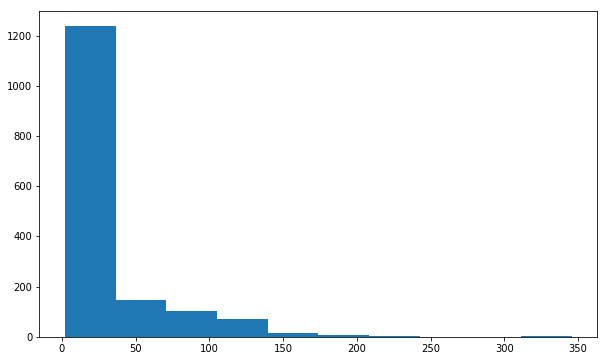

In [96]:
plt.hist(data['answer'].apply(lambda x: len(x.split())))
plt.show()